In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
from pathlib import Path

# FE
from scipy.signal import find_peaks, peak_widths, peak_prominences


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [22]:
pd.set_option('max_columns', 100)
pd.set_option('display.precision', 4)

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
sns.set(font_scale=2.5)

warnings.filterwarnings('ignore')

# 데이터 로드

In [85]:
data_dir = Path('../input/dankook')
sub_dir = Path('../output/')

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'
sub_file = sub_dir / 'submission.csv'

SEED = 2020

In [86]:
df_train = pd.read_csv(train_file, index_col=0)
df_test = pd.read_csv(test_file, index_col=0)

# 변수 생성

ver1: 앞뒤 컬럼의 차이를 변수로 생성

ver2: 5개 컬럼 전의 컬럼과의 차이까지 변수로 생성

In [87]:
wave_columns = df_train.columns.drop(['nObserve','nDetect','class','redshift'])

## Ver1

In [88]:
for j in range(14):
    name = 'diff_' + str(wave_columns[j+1]) + '_' + str(wave_columns[j])
    df_train[name] = df_train[wave_columns[j+1]] - df_train[wave_columns[j]]
    df_test[name] = df_test[wave_columns[j+1]] - df_test[wave_columns[j]]
    print(wave_columns[j+1], ' - ', wave_columns[j], j)

g  -  u 0
r  -  g 1
i  -  r 2
z  -  i 3
dered_u  -  z 4
dered_g  -  dered_u 5
dered_r  -  dered_g 6
dered_i  -  dered_r 7
dered_z  -  dered_i 8
airmass_u  -  dered_z 9
airmass_g  -  airmass_u 10
airmass_r  -  airmass_g 11
airmass_i  -  airmass_r 12
airmass_z  -  airmass_i 13


In [89]:
# 15포인트 랭킹

mag_rank_tr = df_train[wave_columns].rank(axis=1)
mag_rank_tt = df_test[wave_columns].rank(axis=1)

rank_col = []
for col in df_train[wave_columns].columns:
    col = col + '_rank'
    rank_col.append(col)
mag_rank_tr.columns = rank_col
mag_rank_tt.columns = rank_col

df_train = pd.concat([df_train, mag_rank_tr], axis=1)
df_test = pd.concat([df_test,mag_rank_tt], axis=1)

In [90]:
# 측정방법별 파장 차이 비교 변수

diff_col = []
for col in ['u','g','r','i','z']:
    for i in range(2):
        diff_col.append(col + '_' + str(i))

mag_wave_diff_tr = pd.DataFrame(np.zeros((df_train.shape[0], 10)), index=df_train.index)
mag_wave_diff_tt = pd.DataFrame(np.zeros((df_test.shape[0],10)), index=df_test.index)

for i in range(0,10,5):
    for j in range(5):
        mag_wave_diff_tr.loc[:, j+i] = df_train[wave_columns[j]] - df_train[wave_columns[5+j+i]]
        mag_wave_diff_tt.loc[:, j+i] = df_test[wave_columns[j]] - df_test[wave_columns[5+j+i]]
        print(wave_columns[j], ' - ', wave_columns[5+j+i],i+j)

u  -  dered_u 0
g  -  dered_g 1
r  -  dered_r 2
i  -  dered_i 3
z  -  dered_z 4
u  -  airmass_u 5
g  -  airmass_g 6
r  -  airmass_r 7
i  -  airmass_i 8
z  -  airmass_z 9


In [91]:
mag_wave_diff_tr.columns = diff_col
mag_wave_diff_tt.columns = diff_col

df_train = pd.concat([df_train, mag_wave_diff_tr], axis=1)
df_test = pd.concat([df_test, mag_wave_diff_tt], axis=1)



In [92]:
df_train['nObserve'] = df_train['nObserve'].apply(np.log1p)
df_test['nObserve'] = df_test['nObserve'].apply(np.log1p)

df_train['d_obs_det'] = df_train['nObserve'] - df_train['nDetect']
df_test['d_obs_det'] = df_test['nObserve'] - df_test['nDetect']

# feature 선택

In [93]:
df_train.head()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,diff_g_u,diff_r_g,diff_i_r,diff_z_i,diff_dered_u_z,diff_dered_g_dered_u,diff_dered_r_dered_g,diff_dered_i_dered_r,diff_dered_z_dered_i,diff_airmass_u_dered_z,diff_airmass_g_airmass_u,diff_airmass_r_airmass_g,diff_airmass_i_airmass_r,diff_airmass_z_airmass_i,u_rank,g_rank,r_rank,i_rank,z_rank,dered_u_rank,dered_g_rank,dered_r_rank,dered_i_rank,dered_z_rank,airmass_u_rank,airmass_g_rank,airmass_r_rank,airmass_i_rank,airmass_z_rank,u_0,u_1,g_0,g_1,r_0,r_1,i_0,i_1,z_0,z_1,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,18,1.1898,1.1907,1.1890,1.1894,1.1902,0,-2.9272,-1.3273,-1.3371,-0.7328,6.1847,-2.8665,-1.3027,-1.3230,-0.7232,-15.7192,0.0009,-0.0017,3.7600e-04,0.0009,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,3.0,5.0,1.0,2.0,4.0,0.1397,0.0790,0.0544,0.0403,0.0307,22.0742,19.1461,17.8205,16.4831,15.7494,-15.0556
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1,1.2533,1.2578,1.2488,1.2510,1.2555,1,-0.9902,-0.6096,-0.1840,-0.0995,1.7975,-0.9619,-0.5931,-0.1751,-0.1016,-11.8814,0.0046,-0.0091,2.2350e-03,0.0045,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,3.0,5.0,1.0,2.0,4.0,0.0857,0.0574,0.0410,0.0322,0.0343,13.7989,12.8041,12.2037,12.0175,11.9134,-0.3069
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,2,1.0225,1.0241,1.0210,1.0217,1.0233,0,-0.9610,-0.2891,-0.1428,-0.0435,1.2576,-0.9211,-0.2466,-0.1183,-0.0257,-14.2736,0.0016,-0.0031,7.4700e-04,0.0016,15.0,13.0,11.0,9.0,8.0,14.0,12.0,10.0,7.0,6.0,3.0,5.0,1.0,2.0,4.0,0.1787,0.1388,0.0963,0.0718,0.0540,15.7639,14.8013,14.5153,14.3718,14.3267,-0.9014
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,3,1.2054,1.2061,1.2049,1.2051,1.2057,0,-4.4719,-0.9676,-0.3262,-0.2603,5.7190,-4.3590,-0.9074,-0.2926,-0.2395,-18.3498,0.0007,-0.0012,2.4600e-04,0.0006,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,3.0,5.0,1.0,2.0,4.0,0.3070,0.1941,0.1339,0.1003,0.0795,24.4552,19.9827,19.0163,18.6898,18.4289,-1.3906
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,12,1.1939,1.1943,1.1937,1.1938,1.1941,0,-3.7543,-1.6568,-0.7182,-0.3415,5.7888,-3.3376,-1.5709,-0.6727,-0.3144,-16.6820,0.0003,-0.0005,8.8000e-05,0.0003,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,3.0,5.0,1.0,2.0,4.0,0.6820,0.2653,0.1794,0.1339,0.1067,23.2595,19.5049,17.8486,17.1303,16.7885,-9.3609


In [94]:
delete_column=['u','g','r','i','nDetect',
               'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z',
               'dered_u','dered_g','dered_r','dered_i',
               'diff_airmass_g_airmass_u','diff_airmass_r_airmass_g',
               'diff_airmass_i_airmass_r',
               'airmass_u_rank', 'airmass_g_rank', 'airmass_r_rank',
               'airmass_i_rank',
              ]

In [95]:
df_train.drop(delete_column, axis=1, inplace=True)
df_test.drop(delete_column, axis=1, inplace=True)

In [96]:
df_train.shape

(320000, 39)

<AxesSubplot:>

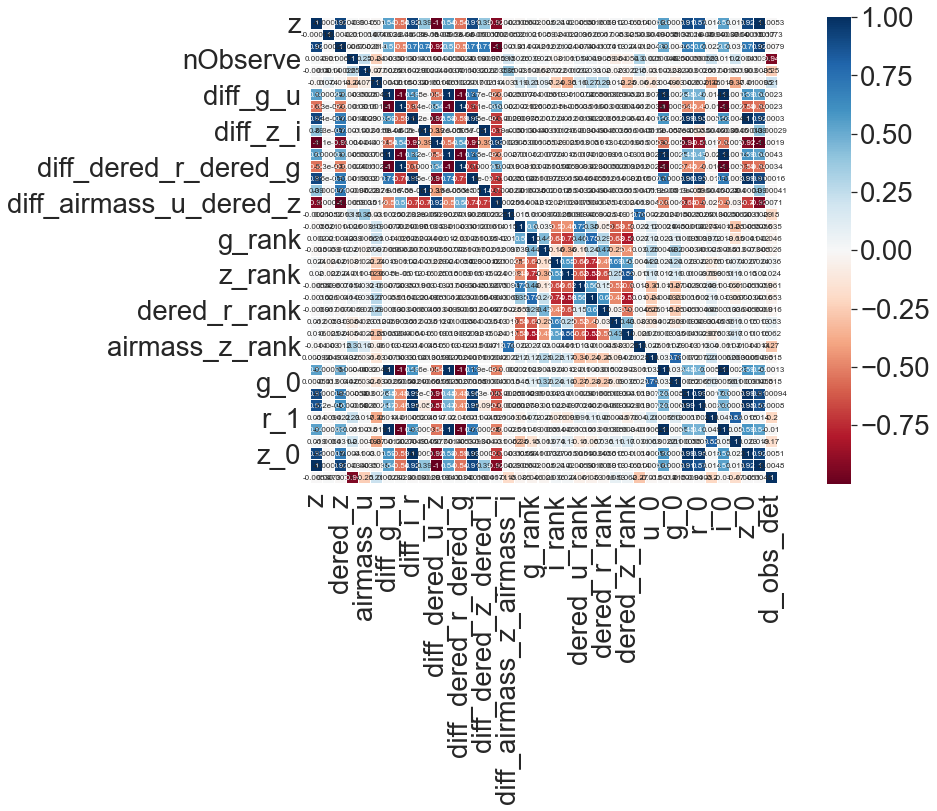

In [97]:
sns.heatmap(df_train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

<AxesSubplot:>

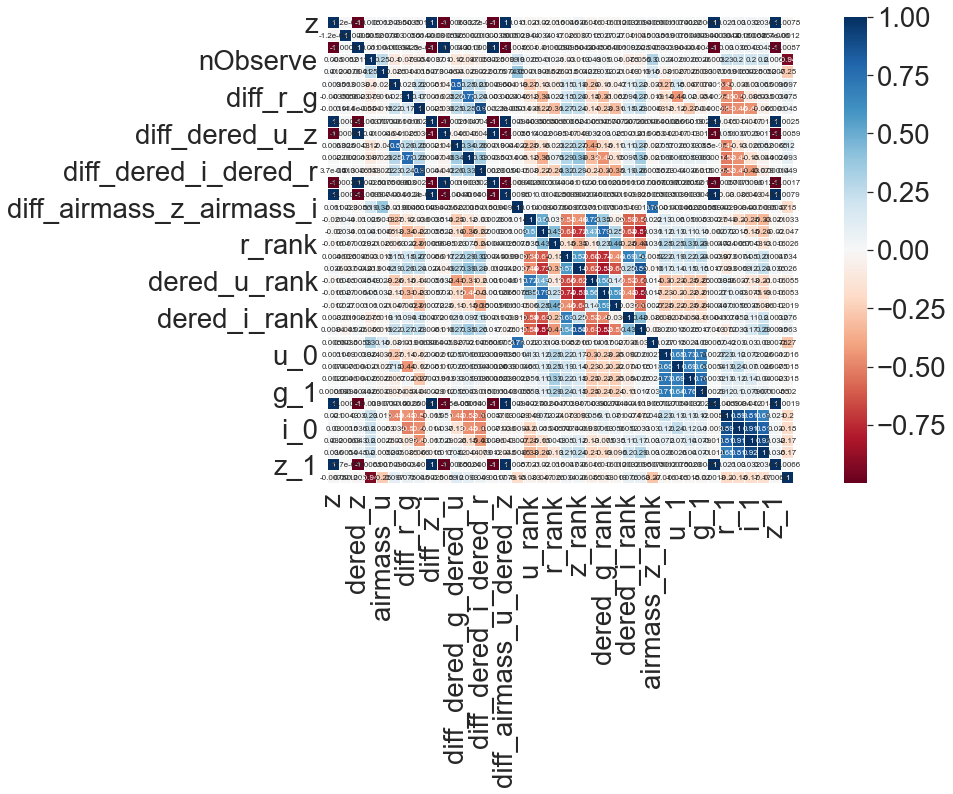

In [98]:
sns.heatmap(df_test.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

# dataset 생성

In [99]:
# train set
X = df_train.drop(columns=['class'], axis=1)
y = df_train.loc[:,'class']

# test set
test = df_test

# train set split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=SEED)

# 모델 학습

In [100]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': 2020
}

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train,y_train)
p = rf_clf.predict(X_test)
print(accuracy_score(p,y_test))

0.9323125


In [101]:
0.93125

0.93125

In [102]:
import xgboost as xg

In [103]:
# Xgboost
xgb_params = {
    'n_jobs' : -1, 
    'n_estimators': 100,
    'eta': 0.3, # learning_rate
    'booster': 'gbtree',
    'gamma': 0,
    'tree_method': 'auto',
    'objective': 'reg:squarederror',
    'random_state': 2020
}

xgb_clf = xg.XGBClassifier(**xgb_params)
xgb_clf.fit(X_train,y_train)
p = xgb_clf.predict(X_test)
print(accuracy_score(p,y_test))

0.9329895833333334


In [104]:
# 0.9346

xgb_clf.fit(X,y)
p = xgb_clf.predict(test)
submission = pd.read_csv('../input/dankook/sample_submission.csv')
submission['class'] = p
submission.to_csv('submission.csv',index=False, encoding='utf-8-sig')

In [105]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error 


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [106]:
df_parmas = {
    'max_features': 'sqrt',
    'random_state': 2020
}

et_parmas = {
    'max_features': 'sqrt',
    'random_state': 2020
}

knn_params = {
    'n_neighbors': 5,
    'n_jobs': -1
}

# SVC
svc_params = {
    'random_state': 2020
}

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': 2020
}

# Extra Trees Parameters
ets_params = {
    'n_jobs' : -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': 2020
}

# AdaBoost Parameters
ada_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'random_state': 2020
}


# Gradient Bossting parameters
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_features': 'sqrt',
    'verbose': 0,
    'random_state': 2020
}

# Xgboost
xgb_params = {
    'n_jobs' : -1, 
    'n_estimators': 100,
    'eta': 0.3, # learning_rate
    'booster': 'gbtree',
    'gamma': 0,
    'tree_method': 'auto',
    'objective': 'reg:squarederror',
    'random_state': 2020
}

In [107]:
estimators = [
    ('df', DecisionTreeClassifier(**df_parmas)),
    ('et', ExtraTreeClassifier(**et_parmas)),
    ('knn', KNeighborsClassifier(**knn_params)),
    ('rf', RandomForestClassifier(**rf_params)),
    ('ets',ExtraTreesClassifier(**ets_params)),
    ('ada',AdaBoostClassifier(**ada_params)),
    ('gb',GradientBoostingClassifier(**gb_params)),
    ('svc', make_pipeline(StandardScaler(), SVC(random_state=2020)))
]
final_estimator = xg.XGBClassifier(**xgb_params)

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator, n_jobs=-1)

In [108]:
stacking_clf.fit(X_train,y_train)

StackingClassifier(estimators=[('df',
                                DecisionTreeClassifier(max_features='sqrt',
                                                       random_state=2020)),
                               ('et',
                                ExtraTreeClassifier(max_features='sqrt',
                                                    random_state=2020)),
                               ('knn', KNeighborsClassifier(n_jobs=-1)),
                               ('rf',
                                RandomForestClassifier(max_features='sqrt',
                                                       n_jobs=-1,
                                                       random_state=2020)),
                               ('ets',
                                ExtraTreesClassifier(max_features='sqrt',
                                                     n_jobs=-1,
                                                     random_...
                                                 interac

In [113]:
p = stacking_clf.predict(X_test)

print('accuracy for stacking :', accuracy_score(y_test,p))

accuracy for stacking : 0.93265625


In [114]:
p = stacking_clf.predict(test)
submission = pd.read_csv('../input/dankook/sample_submission.csv')

submission['class'] = p
submission.to_csv('submission.csv',index=False, encoding='utf-8-sig')

In [115]:
stacking_clf.fit(X,y)
p = stacking_clf.predict(test)
submission = pd.read_csv('../input/dankook/sample_submission.csv')

submission['class'] = p
submission.to_csv('submission.csv',index=False, encoding='utf-8-sig')